## 0. Setup

In [1]:
import torch
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from EIANN import Network
import EIANN.utils as ut
import EIANN.plot as pt

pt.update_plot_defaults()

In [241]:
# Load dataset
X,y = datasets.make_moons(n_samples=200, shuffle=True, noise=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
                   
# Add index to train & test data
train_dataset = []
for i in range(len(y_train)):
    data = torch.tensor(X_train[i]).type(torch.float32)
    target = torch.tensor(y_train[i]).type(torch.float32).unsqueeze(0)
    train_dataset.append((i, data, target))

test_dataset = []
for i in range(len(y_test)):
    data = torch.tensor(X_test[i]).type(torch.float32)
    target = torch.tensor(y_test[i]).type(torch.float32).unsqueeze(0)
    test_dataset.append((i, data, target))    
    
# Put data in dataloader
data_generator = torch.Generator()
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, generator=data_generator)
train_dataloader_onebatch = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

epochs = 30
data_seed = 0
network_seed = 42

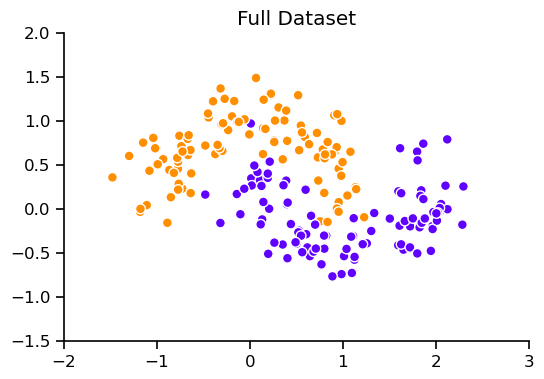

In [242]:
plt.figure(figsize=(6,4))
plt.scatter(X[:,0], X[:,1], 50, edgecolors='w', c=y, cmap=plt.cm.hsv, vmin=-0.15, vmax=1.4)
plt.title('Full Dataset')
plt.xlim(-2,3)
plt.ylim(-1.5,2)
plt.show()

### Backprop (no weight contraints)

Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

Samples:   0%|          | 0/140 [00:00<?, ?it/s]

  0%|          | 0/4201 [00:00<?, ?it/s]

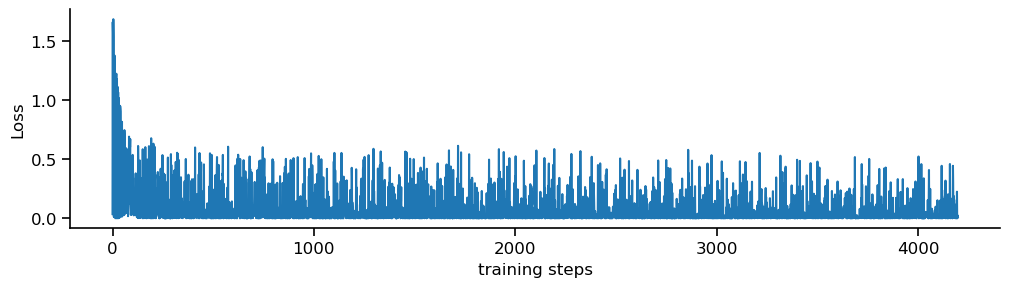

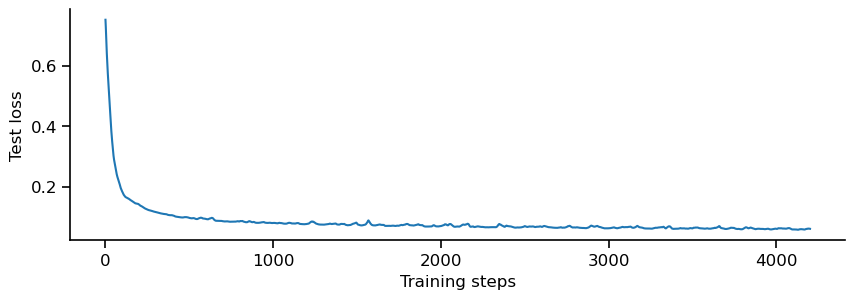

In [339]:
# Create network
network_config = ut.read_from_yaml('../config/binary_classification/EIANN_1_hidden_binary_backprop_relu_SGD_config.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bp_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)

# Train network
data_generator.manual_seed(data_seed)
bp_network.train(train_dataloader,
                 epochs=epochs, 
                 store_history=False,
                 store_weights=True,
                 status_bar=True)

pt.plot_train_loss_history(bp_network)
pt.plot_test_loss_history(bp_network, test_dataloader, stepsize=1)


Test Accuracy 98.33333587646484 %


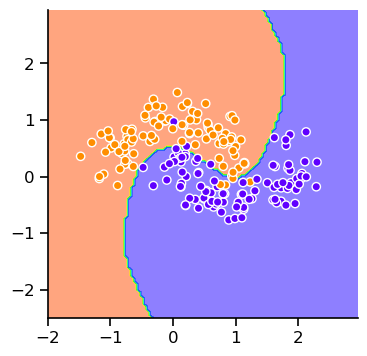

In [368]:
# Compute accuracy on test data
idx, data, target = next(iter(test_dataloader))
output = bp_network(data)
prediction = torch.heaviside(output-0.5,torch.tensor(0.))
test_accuracy = 100 * torch.sum(prediction == target) / len(target)
print(f"Test Accuracy {test_accuracy} %")

# Plot decision boundary (test a grid of X values)
x1_range = [-2,3]
x2_range = [-2.5,3]
# x1_range = (X[:,0].min()-0.1, X[:,0].max()+0.1)
# x2_range = (X[:,1].min()-0.1, X[:,1].max()+0.1)

grid_spacing = 0.05
x1_grid, x2_grid = torch.meshgrid(torch.arange(x1_range[0], x1_range[1], grid_spacing),
                                  torch.arange(x2_range[0], x2_range[1], grid_spacing))

gridpoint_data = torch.vstack([x1_grid.flatten(),x2_grid.flatten()]).T
gridpoint_output = bp_network(gridpoint_data).detach()
gridpoint_output = np.where(gridpoint_output<0.5,0,1)

plt.figure(figsize=(4,4))
plt.contourf(x1_grid, x2_grid, gridpoint_output.reshape(x1_grid.shape), 
             cmap=plt.cm.hsv, alpha=0.5, vmax=1.4)
plt.scatter(X_train[:,0], X_train[:,1], c=y_train, edgecolors='w', cmap=plt.cm.hsv, vmin=-0.15, vmax=1.4)
plt.scatter(X_test[:,0], X_test[:,1], c=y_test, edgecolors='w', cmap=plt.cm.hsv, vmin=-0.15, vmax=1.4)

plt.show()

### Backprop (Dale's Law)

In [ ]:
# Create network
network_config = ut.read_from_yaml('../config/MNIST/EIANN_1_hidden_mnist_backprop_Dale_relu_SGD_config.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

bpDale_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)


# Train network
data_generator.manual_seed(data_seed)
bpDale_network.train(train_dataloader, 
              epochs=epochs, 
              store_history=True,
              store_weights=True,
              status_bar=True)

pt.plot_train_loss_history(bpDale_network)
# pt.plot_test_loss_history(bpDale_network, test_dataloader, stepsize=100)


In [ ]:
from EIANN.plot import *

fig,ax = plt.subplots(2,2,figsize=(12,4))

t = 0
hidden_activity = torch.mean(bpDale_network.H1.E.activity_history[t], dim=1)
output_activity = torch.mean(bpDale_network.Output.E.activity_history[t], dim=1)
ax[0,0].plot(hidden_activity,'--',color='r', label='H1E')
ax[0,0].plot(output_activity,color='r', label='OutputE')
ax[0,0].set_title('Before training')
ax[0,0].legend()

hiddenFBI_activity = torch.mean(bpDale_network.H1.FBI.activity_history[t], dim=1)
outputFBI_activity = torch.mean(bpDale_network.Output.FBI.activity_history[t], dim=1)
ax[1,0].plot(hiddenFBI_activity,'--',color='b', label='H1FBI')
ax[1,0].plot(outputFBI_activity,color='b', label='OutputFBI')


t = -1
hidden_activity = torch.mean(bpDale_network.H1.E.activity_history[t], dim=1)
output_activity = torch.mean(bpDale_network.Output.E.activity_history[t], dim=1)
ax[0,1].plot(hidden_activity,'--',color='r', label='H1E')
ax[0,1].plot(output_activity,color='r', label='OutputE')
ax[0,1].set_title('After training')
ax[0,1].legend()

hiddenFBI_activity = torch.mean(bpDale_network.H1.FBI.activity_history[t], dim=1)
outputFBI_activity = torch.mean(bpDale_network.Output.FBI.activity_history[t], dim=1)
ax[1,1].plot(hiddenFBI_activity,'--',color='b', label='H1FBI')
ax[1,1].plot(outputFBI_activity,color='b', label='OutputFBI')

plt.show()

## BTSP

In [ ]:
# Create network
network_config = ut.read_from_yaml('../config/MNIST/EIANN_1_hidden_mnist_BTSP_config.yaml')
layer_config = network_config['layer_config']
projection_config = network_config['projection_config']
training_kwargs = network_config['training_kwargs']

btsp_network = Network(layer_config, projection_config, seed=network_seed, **training_kwargs)


# Train network
data_generator.manual_seed(data_seed)
btsp_network.train(train_dataloader, 
                   epochs=epochs, 
                   store_history=False, 
                   store_weights=True, 
                   status_bar=True)

pt.plot_train_loss_history(btsp_network)
# pt.plot_test_loss_history(btsp_network, test_dataloader, stepsize=100)
